# Project 

FAIN Thony  
LONCHAMBON Alexis  

## Install

### Install Commands

In [2]:
# !pip install tqdm
# !pip install time

# %pip install --force-reinstall -v "ipywidgets == 7.7.2"
# %pip install --force-reinstall -v "jupyterlab_widgets == 1.1.1"

### Imports

In [1]:
# ALL IMPORTS FOR CODE 

import os
import sys
import numpy as np
import pandas as pd
import time
import json
import math
import requests
import shutil
import PIL.Image
import webcolors
from types import SimpleNamespace
from PIL.ExifTags import TAGS
from IPython.display import display
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from pandas import json_normalize
from IPython.display import Image, HTML
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans, MiniBatchKMeans

### Settings

In [3]:
## CLUSTERING

# Numbers of color clusters for classification
NUM_CLUSTERS = 3


## DATA

#Database names
DB_NAME = "db.json"
IMG_DB_NAME = "db_images.json"

#Image paths
IMG_FOLDER = "img"
PLT_FOLDER = "plt"


### Global Methods

In [11]:
# ALL GLOBAL FUNCITONS

def path_to_image_html(path):
    '''Transforms an url to an image balise for displaying'''
    return '<img width="500" src="'+ path + '"/>'

def format_exif(data):
    '''Formats exifs to HTML display'''
    out = ""
    for tag, value in data.items():
        if tag in TAGS:
            out+=f"{TAGS[tag]}: {value}<br>"
    return out

def closest_color(col):
    '''Returns the name of the closest color'''
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - col[0]) ** 2
        gd = (g_c - col[1]) ** 2
        bd = (b_c - col[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def format_exif_json(data):
    '''Formats exifs to a dict for JSON parsing'''

    if(not data) :
        return None
    
    #This creates a object flexible enough to add attributes dynamically
    out = SimpleNamespace()

    for tag, value in data.items():
        if tag in TAGS:
            tagS = TAGS[tag]

            #Some tags are ignored because they contain lots of useless bytes values that are a pain to format and cannot be used in our project anyway
            if tagS in ["MakerNote", "UserComment", "InterColorProfile", "ComponentsConfiguration"]:
                continue

            #Some string values contain empty
            if isinstance(value, str):
                value = value.rstrip('\x00').rstrip('\u0000')

            # add attribute to our object
            setattr(out,tagS, value)
    #We need to return it as a dict for JSON parsing
    return out.__dict__

def get_colors(path):
    '''Returns a plot with the colors'''
    if not os.path.exists(PLT_FOLDER):
        # Create a new directory because it does not exist
        os.makedirs(PLT_FOLDER)
    if not os.path.exists(f"{PLT_FOLDER}/{IMG_FOLDER}"):
        # Create a new directory because it does not exist
        os.makedirs(f"{PLT_FOLDER}/{IMG_FOLDER}")

    #Open image
    imgfile = PIL.Image.open(path).convert('RGBA')

    #We want a certain number of dominant colors
    numClusters = NUM_CLUSTERS

    try:
        plot.clf()

        # Resize to speed up image handling
        imgfile = imgfile.resize((512,512), PIL.Image.Resampling.LANCZOS)

        # Convert to 2D array
        imgfile = np.array(imgfile)
        w, h, d = tuple(imgfile.shape)
        image_array = np.reshape(imgfile, (w * h, d))

        # numarray = np.array(imgfile.getdata(), np.uint8)

        #Clustering with MiniBatchKmeans
        clusters = MiniBatchKMeans(n_clusters=numClusters, random_state=0, n_init=2)
        # clusters = KMeans(n_clusters=numClusters, random_state=0, n_init=2, n_jobs=4)
        clusters.fit(image_array)
        npbins = np.arange(0, numClusters+1)
        histogram = np.histogram(clusters.labels_, bins=npbins)
        labels = np.unique(clusters.labels_)
        barlist = plot.bar(labels, histogram[0])
        for i in range(numClusters):
            barlist[i].set_color(
                "#%02x%02x%02x"
                % (
                    math.ceil(clusters.cluster_centers_[i][0]),
                    math.ceil(clusters.cluster_centers_[i][1]),
                    math.ceil(clusters.cluster_centers_[i][2]),
                )
            )
        plot.savefig(f"{PLT_FOLDER}/{path}")
        return clusters
    except Exception as inst:
        print(f"RIP for {path} : {inst}") 
        return None
        
            
def download_image(url):
    '''Downloads the image from an url to the img path'''


    filepath = os.path.join(IMG_FOLDER, os.path.basename(url))

    #creates the directory to avoid a crash (I love python...)
    if not os.path.exists(IMG_FOLDER):
        # Create a new directory because it does not exist
        os.makedirs(IMG_FOLDER)
        # print("The new directory is created!")
    headers = {"User-Agent": "Mozilla/5.0"}

    #Ignore the download if the file exists
    if os.path.isfile(filepath) :
        return filepath

    #Download code
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(filepath, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return filepath

## Dataset Initialisation

### Getting the images and setting up the database

In [9]:

endpoint_url = "https://query.wikidata.org/sparql"
imgmax = 1000

# Get cities
query = """SELECT DISTINCT ?planeLabel ?entry ?image {
  ?plane wdt:P31 wd:Q15056993;
               wdt:P729 ?entry;
               wdt:P729 ?retirement;
               wdt:P18 ?image.
      
  SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
} LIMIT 1000"""

#get the results from the query from wikidata
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


#array for dataframe
array = []

#array for JSON formatting
db = []
results = get_results(endpoint_url, query)
res = results["results"]["bindings"]
i = 0

#Parsing all results 
for result in tqdm(res):
    i+=1

    #Weird formats are ignored.
    filename, file_extension = os.path.splitext(os.path.basename(result["image"]["value"]))
    if file_extension not in [".png", ".jpg"] :
        continue

    #Download and get image exif data
    path = download_image(result["image"]["value"])
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    
    #Parse data for JSON DB
    db.append(
        {
            "name" : result["planeLabel"]["value"],
            "img" : path,
            "width" : img.width,
            "height" : img.height,
            "orientation" : ("Paysage" if img.width > img.height else "Portrait"),
            "tags" : format_exif_json(exif_data)
        }
    )

    #Parse data for dataframe display
    array.append(
        (
            result["planeLabel"]["value"],
            result["entry"]["value"],
            path,
            img.width,
            img.height,
            ("Paysage" if img.width > img.height else "Portrait"),
            exif_data
        )
    )


dataframe = pd.DataFrame(array, columns=["planeLabel", "entry", "image", "width", "height", "orientation", "data"])
dataframe = dataframe.astype(
    dtype={"planeLabel": "<U200", "entry" : "<U200", "image": "<U200", "width": "int64", "height": "int64", "orientation" : "<U200"}
)
# srt = dataframe.sort_values("data")


# Serializing json
json_object = json.dumps(db, indent=4, default=lambda o: f"{o}")
 
# Writing to db.json
with open(DB_NAME, "w") as outfile:
    outfile.write(json_object)

#HTML Display
pd.set_option('display.max_colwidth', 100)

# HTML(srt.to_html(escape=False ,formatters=dict(image=path_to_image_html)))

100%|██████████| 553/553 [07:13<00:00,  1.27it/s]


### Filtering data

In [10]:

# We remove data if there are no tags
filter1 = dataframe["data"] != "None"
filtered = dataframe.where(filter1).dropna()
# HTML(filtered.to_html(escape=False ,formatters=dict(image=path_to_image_html)))
# filtered
mapped = filtered
# bars = get_colors(mapped["image"])
# mapped["bars"] = mapped['image'].apply(lambda x: get_colors(x))
# mapped["data"] = mapped['data'].apply(lambda x: format_exif(x))
# mapped
# HTML(mapped.to_html(escape=False ,formatters=dict(image=path_to_image_html)))
mapped


,planeLabel,entry,image,width,height,orientation,data
5,Iliouchine Il-14,1954-11-30T00:00:00Z,img/%D0%A1%D0%A1%D0%A1%D0%A0-91612%20IL14%20Private%20-%20Penguin%20livery%20-%20by%20name%20Mik...,1200,675,Paysage,"{296: 2, 34665: 228, 270: 'SONY DSC', 271: 'SONY', 272: 'DSLR-A200', 305: 'Adobe Photoshop CC 20..."
7,Yak-3,1944-04-01T00:00:00Z,img/CF15%20Yak-3%20ZK-VVS%20040415%2001.jpg,2000,1333,Paysage,"{296: 2, 34665: 230, 271: 'Canon', 272: 'Canon EOS 60D', 305: 'Adobe Photoshop Lightroom 5.0 (Wi..."
8,C-17 Globemaster III,1995-01-17T00:00:00Z,img/C-17%204.jpg,1588,970,Paysage,"{296: 2, 34665: 860, 270: 'A C-17 Globemaster, 446th Airlift Wing, McChord AFB, Wa. conducts an ..."
11,Lockheed S-3 Viking,1974-01-01T00:00:00Z,img/S-3B%20Viking%20launched%20off%20the%20flight%20deck%20of%20the%20USS%20Theodore%20Roosevel.jpg,3470,2257,Paysage,"{34853: {0: b'\x02\x02\x00\x00'}, 296: 2, 34665: 776, 270: '051006-N-2838C-005 Persian Gulf Octo..."
13,Boeing F/A-18E/F Super Hornet,2001-09-01T00:00:00Z,img/081102-N-0000C-002.jpg,2100,1500,Paysage,"{296: 2, 34665: 828, 270: '081102-N-0000C-002 AFGHANISTAN (Nov. 2, 2008) An F/A-18 Hornet from t..."
...,...,...,...,...,...,...,...
482,Lavochkin La-9,1947-01-01T00:00:00Z,img/LavochkinLa-9.jpg,1560,1152,Paysage,"{296: 2, 34665: 186, 271: 'Canon', 272: 'Canon PowerShot A610', 274: 1, 306: '2006:04:15 15:36:5..."
485,E-Jet,2004-03-17T00:00:00Z,img/EI-RDB%20Embraer%20175%20Alitalia%20BCN.jpg,4722,3148,Paysage,"{256: 4722, 257: 3148, 258: (8, 8, 8), 262: 2, 296: 2, 34665: 296, 271: 'Canon', 272: 'Canon EOS..."
486,Winjeel,1955-01-01T00:00:00Z,img/CAC%20Winjeel.jpg,2048,1365,Paysage,"{296: 3, 34665: 244, 271: 'Canon', 272: 'Canon EOS 350D DIGITAL', 305: 'Paint Shop Pro Photo 11...."
487,Bell H-13 Sioux,1946-01-01T00:00:00Z,img/Bell%2047-OH-13%20inflight%20bw.jpg,1419,982,Paysage,"{34665: 2142, 274: 1, 306: '2014:08:24 15:42:14', 59932: b'\x1c\xea\x00\x00\x00\x08\x00\x00\x00\..."


## Dominant Color Annotation

### Load the parsed data

In [7]:
# Opening JSON file
f = open(DB_NAME)
  
# returns JSON object as a dictionary
data = json.load(f)

df = pd.DataFrame(data)

df

,name,img,width,height,orientation,tags
0,Mirage F1,img/Ecuadorian%20Air%20Force%20Dassault%20Mira...,2800,1810,Paysage,None
1,ATR 72,img/ATR%20ATR-72-202%2C%20LOT%20-%20Polish%20A...,1200,800,Paysage,None
2,Boeing Vertol CH-47 Chinook,img/Boeing%20Vertol%20CH-47%20Chinook%203-view...,574,385,Paysage,None
3,Il-2 Sturmovik,img/Il2%20sturmovik.jpg,650,234,Paysage,None
4,Mil Mi-1,img/Mi-1m%20museum.jpg,640,468,Paysage,None
...,...,...,...,...,...,...
496,Short C-23 Sherpa,img/Short%20C-23A%20Sherpa%20%28330-200%29%2C%...,1024,678,Paysage,None
497,Tomtit,img/Hawker%20Tomtit%20%E2%80%98K1786%E2%80%99%...,3773,2515,Paysage,"{'ImageWidth': 6016, 'ImageLength': 4000, 'Bit..."
498,Vildebeest,img/Vickers%20Vildebeest%20in%20flight.jpg,352,317,Paysage,None
499,Savoia-Marchetti S.55,img/Aeroflot%20Savoia-Marchetti%20S.55P.jpg,1072,396,Paysage,None


### Dominant Color annotation 

100%|██████████| 501/501 [05:40<00:00,  1.47it/s]


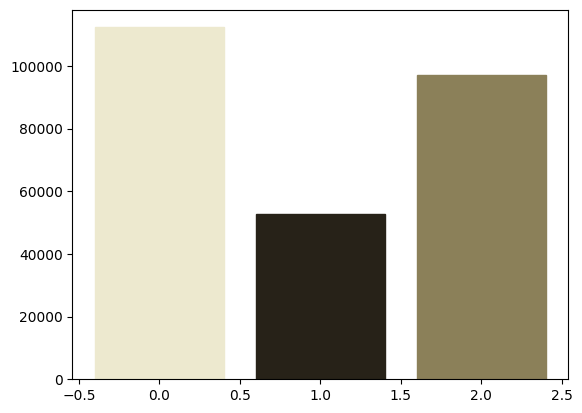

In [10]:
for entry in tqdm(data):
    # Get image path
    path = entry["img"]

    # Process image dominant colors with Kmeans
    clusters = get_colors(path)

    # If it worked and did not crash and burned, tag the image with the dominant colors
    if clusters:
        i = 0
        colorlist = []

        for color in clusters.cluster_centers_:
            c = {}
            c["R"] = int(color[0])
            c["G"] = int(color[1])
            c["B"] = int(color[2])

            colorlist.append(c)
        entry["colors"] = colorlist

    # Serializing json
    json2 = json.dumps(data, indent=4, default=lambda o: f"{o}")
    
    # Writing to db_images.json
    with open(IMG_DB_NAME, "w") as outfile:
        outfile.write(json2)

    #HTML Display settings
    pd.set_option('display.max_colwidth', 100)


### Open Color-Tagged database

In [190]:
# Opening JSON file
f = open(IMG_DB_NAME)
  
# returns JSON object as 
# a dictionary
data = json.load(f)

df = pd.DataFrame(data)

df

,name,img,width,height,orientation,tags,colors
0,Mirage F1,img/Ecuadorian%20Air%20Force%20Dassault%20Mira...,2800,1810,Paysage,None,"[{'R': 210, 'G': 217, 'B': 227}, {'R': 122, 'G..."
1,ATR 72,img/ATR%20ATR-72-202%2C%20LOT%20-%20Polish%20A...,1200,800,Paysage,None,"[{'R': 130, 'G': 138, 'B': 143}, {'R': 75, 'G'..."
2,Boeing Vertol CH-47 Chinook,img/Boeing%20Vertol%20CH-47%20Chinook%203-view...,574,385,Paysage,None,"[{'R': 254, 'G': 254, 'B': 254}, {'R': 45, 'G'..."
3,Il-2 Sturmovik,img/Il2%20sturmovik.jpg,650,234,Paysage,None,"[{'R': 157, 'G': 157, 'B': 157}, {'R': 55, 'G'..."
4,Mil Mi-1,img/Mi-1m%20museum.jpg,640,468,Paysage,None,"[{'R': 211, 'G': 225, 'B': 233}, {'R': 52, 'G'..."
...,...,...,...,...,...,...,...
496,Short C-23 Sherpa,img/Short%20C-23A%20Sherpa%20%28330-200%29%2C%...,1024,678,Paysage,None,"[{'R': 146, 'G': 175, 'B': 198}, {'R': 94, 'G'..."
497,Tomtit,img/Hawker%20Tomtit%20%E2%80%98K1786%E2%80%99%...,3773,2515,Paysage,"{'ImageWidth': 6016, 'ImageLength': 4000, 'Bit...","[{'R': 145, 'G': 154, 'B': 155}, {'R': 46, 'G'..."
498,Vildebeest,img/Vickers%20Vildebeest%20in%20flight.jpg,352,317,Paysage,None,"[{'R': 218, 'G': 218, 'B': 218}, {'R': 136, 'G..."
499,Savoia-Marchetti S.55,img/Aeroflot%20Savoia-Marchetti%20S.55P.jpg,1072,396,Paysage,None,"[{'R': 53, 'G': 53, 'B': 53}, {'R': 164, 'G': ..."


In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

results = []
array = []
predict = []
favList = ["likes", "yikes"]
outList = ["training", "predict"]
for line in data:
    
    c1 = line["colors"][0]
    c1 =  closest_color((c1["R"], c1["G"], c1["B"]))
    c2 = line["colors"][1]
    c2 =  closest_color((c2["R"], c2["G"], c2["B"]))
    c3 = line["colors"][2]
    c3 =  closest_color((c3["R"], c3["G"], c3["B"]))

    exif = line["tags"]
    

    if(exif):
        Make = exif["Make"] if "Make" in exif else None
        ResolutionUnit = exif["ResolutionUnit"] if "ResolutionUnit" in exif else None
        Model = exif["Model"] if "Model" in exif else None
        XResolution = exif["XResolution"] if "XResolution" in exif else None
        YResolution = exif["YResolution"] if "YResolution" in exif else None
        ISOSpeedRatings = exif["ISOSpeedRatings"] if "ISOSpeedRatings" in exif else None

        # 10 out of 250 images will be used for prediction. The rest is training
        if(random.randint(0, 250) < 100):
            predict.append(
                (
                    c1,
                    c2,
                    c3,
                    Make,
                    ResolutionUnit,
                    Model,
                    XResolution,
                    YResolution,
                    ISOSpeedRatings,
                    line["orientation"]
                )
            )
        else:
            array.append(
                (
                    c1,
                    c2,
                    c3,
                    Make,
                    ResolutionUnit,
                    Model,
                    XResolution,
                    YResolution,
                    ISOSpeedRatings,
                    line["orientation"]
                )
            )
            # We randomly like or not an image. Later, we will chose the images we like (maybe)
            results.append(random.choices(favList, weights= [1, 10]))


dataframe = pd.DataFrame(array, columns=["color1", "color2", "color3", "Make", "ResolutionUnit", "Model", "XResolution", "YResolution", "ISOSpeedRatings", "orientation"])
predict = pd.DataFrame(predict, columns=["color1", "color2", "color3", "Make", "ResolutionUnit", "Model", "XResolution", "YResolution", "ISOSpeedRatings", "orientation"])

results = pd.DataFrame(results, columns=["Favorite"])
encoded = pd.DataFrame()
pred_en = pd.DataFrame()
en_resu = pd.DataFrame()
# generating numerical labels
le11 = LabelEncoder()
encoded["color1_en"] = le11.fit_transform(dataframe["color1"])
pred_en["color1_en"] = le11.fit_transform(predict["color1"])
le12 = LabelEncoder()
encoded["color2_en"] = le12.fit_transform(dataframe["color2"])
pred_en["color2_en"] = le11.fit_transform(predict["color2"])
le13 = LabelEncoder()
encoded["color3_en"] = le13.fit_transform(dataframe["color3"])
pred_en["color3_en"] = le11.fit_transform(predict["color3"])

# generating numerical labels
le2 = LabelEncoder()
encoded["Make_en"] = le2.fit_transform(dataframe["Make"])
pred_en["Make_en"] = le2.fit_transform(predict["Make"])

# Generating ResolutionUnit labels
le_ResolutionUnit = LabelEncoder()
encoded["ResolutionUnit_en"] = le_ResolutionUnit.fit_transform(dataframe["ResolutionUnit"])
pred_en["ResolutionUnit_en"] = le_ResolutionUnit.fit_transform(predict["ResolutionUnit"])

# Generating Model labels
le_Model = LabelEncoder()
encoded["Model_en"] = le_Model.fit_transform(dataframe["Model"])
pred_en["Model_en"] = le_Model.fit_transform(predict["Model"])

# Generating XResolution labels
le_XResolution = LabelEncoder()
encoded["XResolution_en"] = le_XResolution.fit_transform(dataframe["XResolution"])
pred_en["XResolution_en"] = le_XResolution.fit_transform(predict["XResolution"])

# Generating YResolution labels
le_YResolution = LabelEncoder()
encoded["YResolution_en"] = le_YResolution.fit_transform(dataframe["YResolution"])
pred_en["YResolution_en"] = le_YResolution.fit_transform(predict["YResolution"])

# Generating ISOSpeedRatings labels
le_ISOSpeedRatings = LabelEncoder()
encoded["ISOSpeedRatings_en"] = le_ISOSpeedRatings.fit_transform(dataframe["ISOSpeedRatings"])
pred_en["ISOSpeedRatings_en"] = le_ISOSpeedRatings.fit_transform(predict["ISOSpeedRatings"])

# generating numerical labels
le3 = LabelEncoder()
encoded["orientation_en"] = le2.fit_transform(dataframe["orientation"])
pred_en["orientation_en"] = le2.fit_transform(predict["orientation"])


# generating numerical labels
le_res = LabelEncoder()
en_resu["Favorite_en"] = le_res.fit_transform(results["Favorite"])

# dataframe 
# encoded


dataframe.join(encoded).join(results).join(en_resu)

,color1,color2,color3,Make,ResolutionUnit,Model,XResolution,YResolution,ISOSpeedRatings,orientation,...,color3_en,Make_en,ResolutionUnit_en,Model_en,XResolution_en,YResolution_en,ISOSpeedRatings_en,orientation_en,Favorite,Favorite_en
0,darkgray,darkolivegreen,firebrick,SONY,2.0,DSLR-A200,72.0,72.0,100.0,Paysage,...,8,12,0,27,26,26,2,0,yikes,1
1,gainsboro,saddlebrown,silver,Canon,2.0,Canon EOS 60D,500.0,500.0,100.0,Paysage,...,19,1,0,13,19,19,2,0,yikes,1
2,whitesmoke,gray,darkslategray,None,2.0,None,72.0,72.0,NaN,Paysage,...,6,15,0,59,26,26,10,0,yikes,1
3,whitesmoke,darkslategray,darkgray,None,2.0,None,300.0,300.0,NaN,Paysage,...,3,15,0,59,15,15,10,0,yikes,1
4,gray,silver,darkslategray,None,2.0,None,300.0,300.0,NaN,Portrait,...,6,15,0,59,15,15,10,1,yikes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,whitesmoke,darkslategray,darkgray,None,2.0,None,300.0,300.0,NaN,Paysage,...,3,15,0,59,15,15,10,0,likes,0
129,tan,darkslategray,gray,None,2.0,None,300.0,300.0,NaN,Paysage,...,11,15,0,59,15,15,10,0,yikes,1
130,skyblue,darkslategray,gainsboro,NIKON CORPORATION,2.0,NIKON D3200,505.8333,505.8333,200.0,Paysage,...,9,8,0,44,20,20,4,0,yikes,1
131,lightsteelblue,dimgray,black,Canon,3.0,Canon EOS 350D DIGITAL,87.0,87.0,400.0,Paysage,...,0,1,1,6,27,27,7,0,yikes,1


In [192]:
predict.join(pred_en)

,color1,color2,color3,Make,ResolutionUnit,Model,XResolution,YResolution,ISOSpeedRatings,orientation,color1_en,color2_en,color3_en,Make_en,ResolutionUnit_en,Model_en,XResolution_en,YResolution_en,ISOSpeedRatings_en,orientation_en
0,lightgray,darkslategray,gray,None,2.0,None,300.0,300.0,NaN,Paysage,11,6,10,14,0,57,12,12,11,0
1,lightsteelblue,darkslategray,slategray,NIKON CORPORATION,2.0,NIKON D2X,300.0,300.0,100.0,Paysage,13,6,21,5,0,36,12,12,3,0
2,slategray,cadetblue,darkslategray,Canon,2.0,Canon PowerShot SD770 IS,300.0,300.0,250.0,Paysage,19,1,6,1,0,19,12,12,7,0
3,lightsteelblue,dimgray,lightgray,None,2.0,None,72.0,72.0,NaN,Paysage,13,7,11,14,0,57,21,21,11,0
4,lavender,darkslategray,olivedrab,NIKON CORPORATION,2.0,NIKON D700,281.686,281.686,250.0,Paysage,9,6,16,5,0,45,11,11,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,lightgray,black,gray,None,NaN,None,None,None,NaN,Paysage,11,0,10,14,2,57,25,25,11,0
99,lightsteelblue,black,darkslategray,None,2.0,None,300.0,300.0,NaN,Portrait,13,0,6,14,0,57,12,12,11,1
100,slategray,darkgray,darkslategray,Canon,2.0,Canon PowerShot A610,180.0,180.0,NaN,Paysage,19,3,6,1,0,17,6,6,11,0
101,steelblue,gainsboro,darkslategray,Canon,2.0,Canon EOS 550D,240.0,240.0,100.0,Paysage,21,8,6,1,0,7,8,8,3,0


In [193]:
rfc = RandomForestClassifier(
    n_estimators=10,
    max_depth=5,
    random_state=0,
)
rfc = rfc.fit(encoded.values, en_resu.values.ravel())

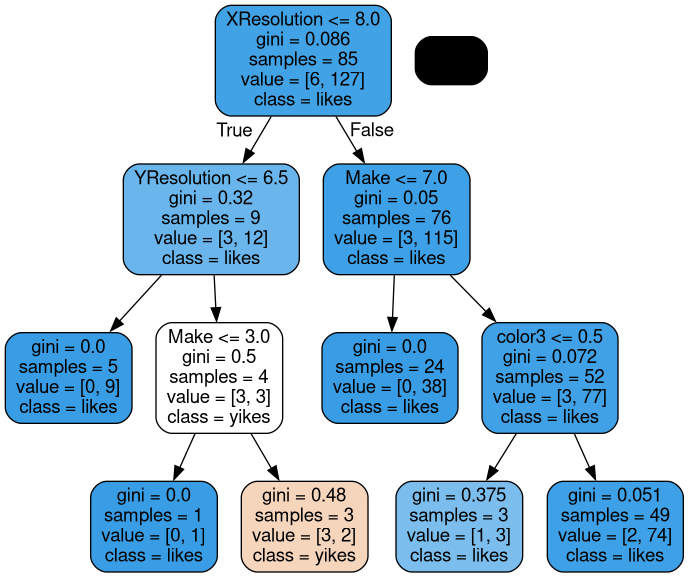

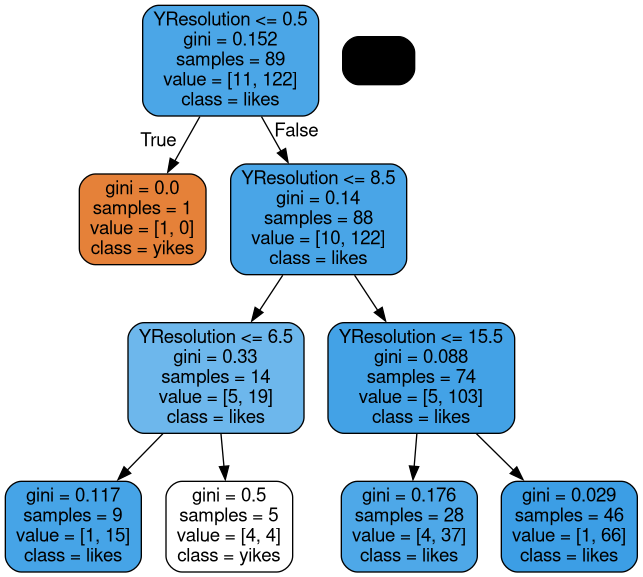

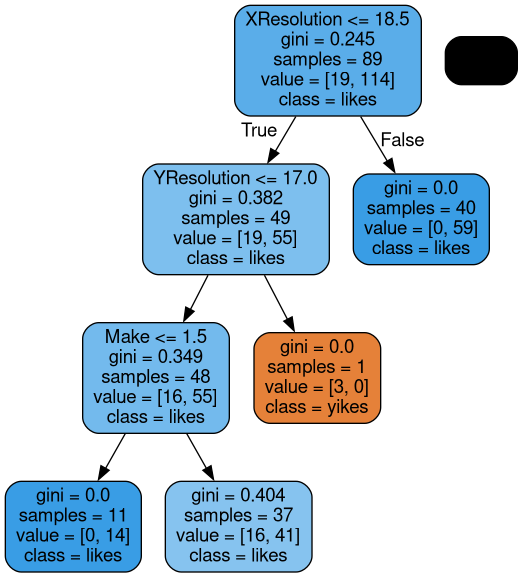

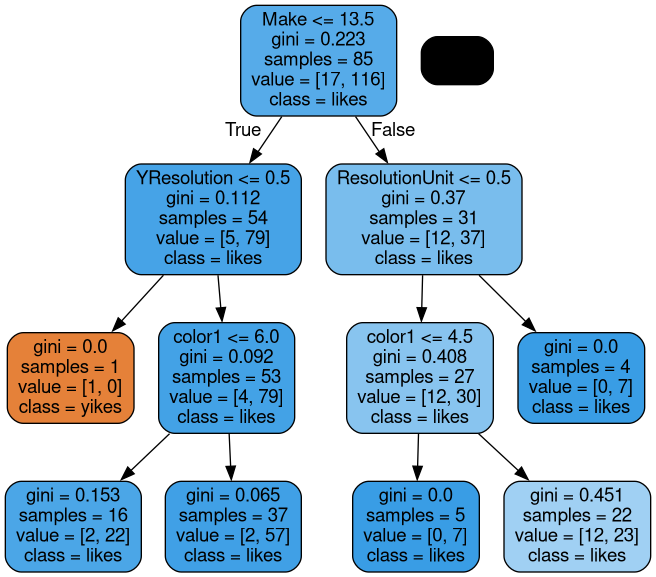

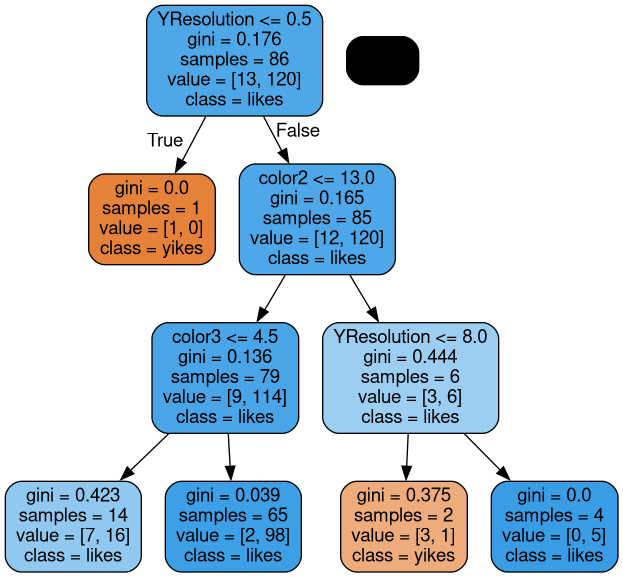

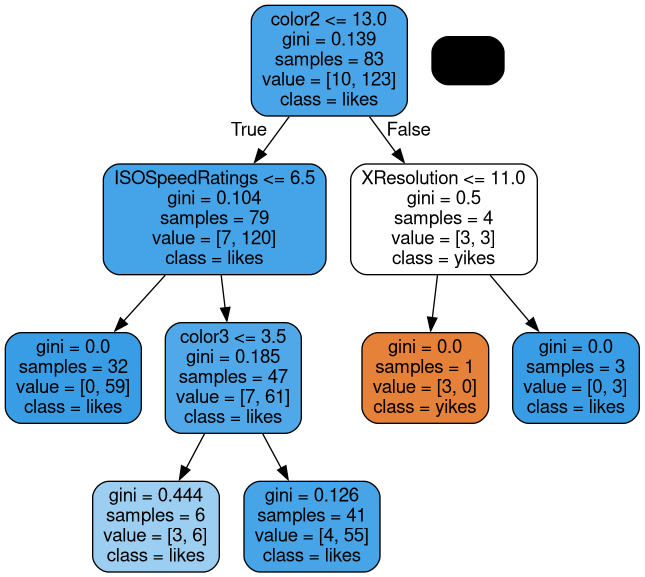

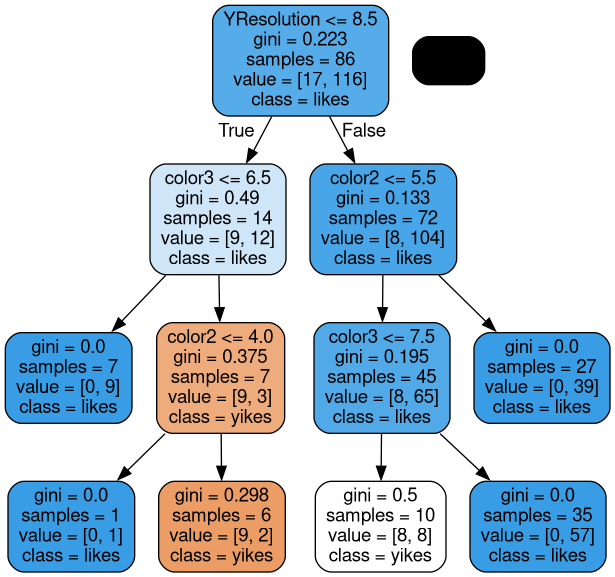

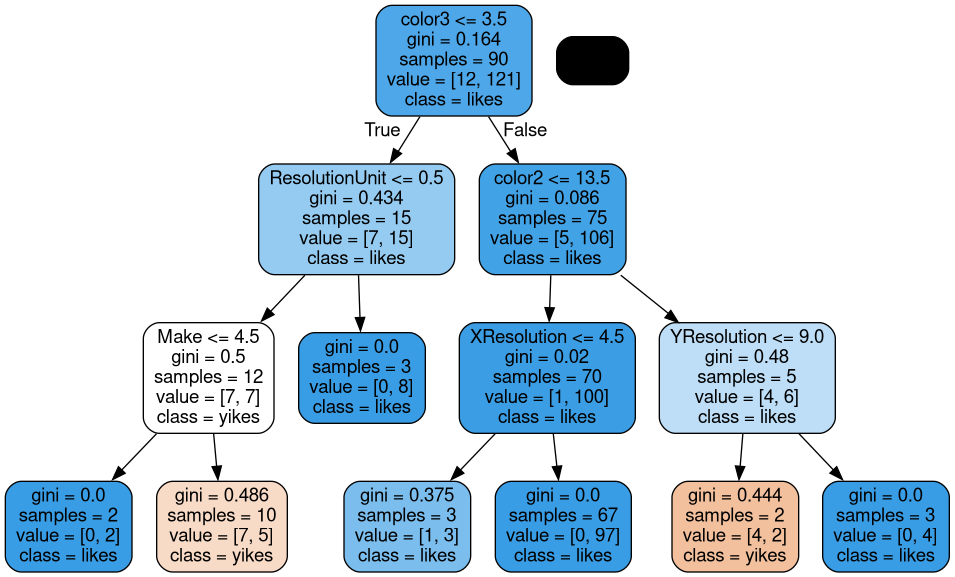

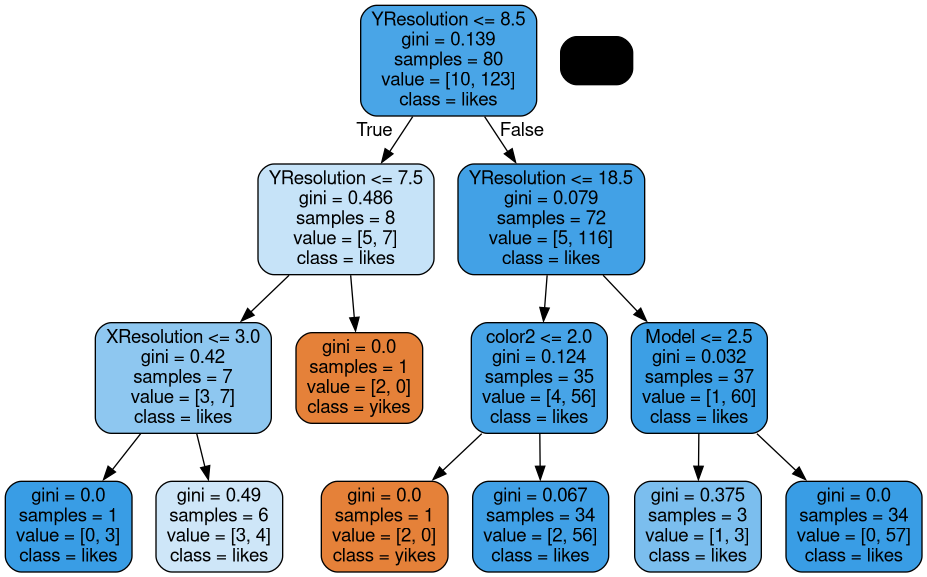

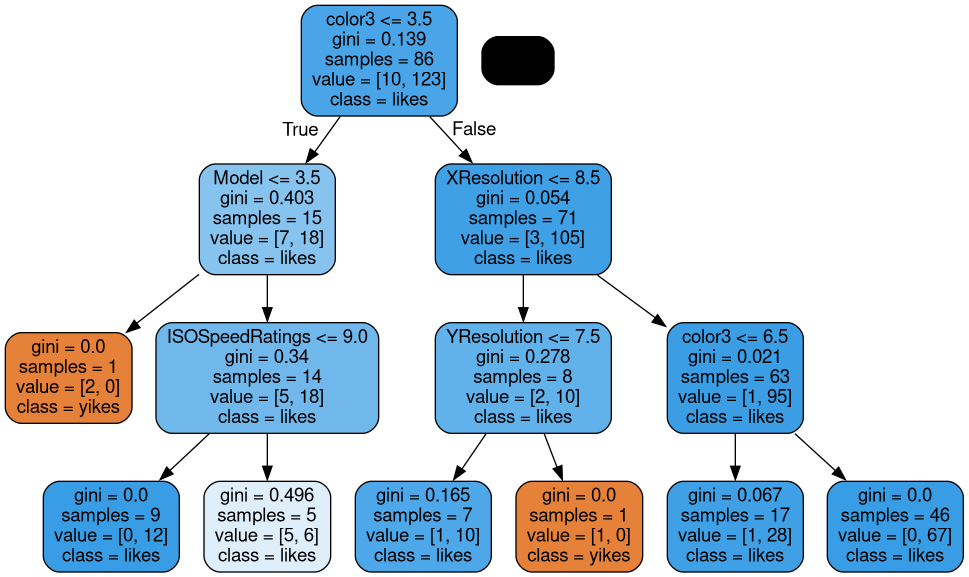

In [194]:
import graphviz
import pydotplus
from sklearn import tree

for i in range(10):
    dot_data = tree.export_graphviz(
        rfc.estimators_[i],
        out_file=None,
        feature_names=dataframe.columns,
        filled=True,
        rounded=True,
        class_names=le_res.inverse_transform(en_resu.Favorite_en.unique()),
    )
    graph = graphviz.Source(dot_data)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    img = Image(pydot_graph.create_png())
    display(img)

In [195]:
prediction = rfc.predict(pred_en)
prediction2 = le_res.inverse_transform(prediction)

prediction = pd.DataFrame(prediction, columns=["Fav"])

prediction2 = pd.DataFrame(prediction2)
predict.join(prediction).join(prediction2).sort_values("Fav")

/mnt/e/Code/CPE-Keelah/S8-MachineLearning/env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,color1,color2,color3,Make,ResolutionUnit,Model,XResolution,YResolution,ISOSpeedRatings,orientation,Fav,0
78,lightsteelblue,lightslategray,darkslategray,NIKON CORPORATION,2.0,NIKON D3,240.0,240.0,800.0,Paysage,0,likes
0,lightgray,darkslategray,gray,None,2.0,None,300.0,300.0,NaN,Paysage,1,yikes
74,whitesmoke,darkolivegreen,darkgray,NIKON CORPORATION,2.0,NIKON D50,300.0,300.0,NaN,Paysage,1,yikes
73,slategray,darkgray,darkolivegreen,Canon,2.0,Canon EOS 20D,72.0,72.0,400.0,Paysage,1,yikes
72,gray,darkslategray,darkgray,None,2.0,None,1100.0,1100.0,NaN,Paysage,1,yikes
...,...,...,...,...,...,...,...,...,...,...,...,...
29,lightsteelblue,dimgray,beige,NIKON,2.0,E8800,300.0,300.0,50.0,Paysage,1,yikes
28,lightslategray,darkslategray,dimgray,None,2.0,None,300.0,300.0,NaN,Paysage,1,yikes
27,steelblue,silver,dimgray,SONY,2.0,DSLR-A200,72.0,72.0,100.0,Paysage,1,yikes
37,lightsteelblue,darkslategray,dimgray,Canon,2.0,Canon EOS 350D DIGITAL,72.0,72.0,200.0,Paysage,1,yikes
